In [37]:
import os
import re
import glob
import datetime
import warnings

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline

In [2]:
## This section caches all MODIS MCD43A4 file names in the format listed below, where '?' is a wildcard
try:
    with open('/g/data/oe9/modis_tile_file_list.txt') as f:
        reflectance_file_cache = sorted(l.strip() for l in f.readlines())
except:
    reflectance_file_cache =  sorted(glob.glob(
        '/g/data/u39/public/data/modis/lpdaac-tiles-c6/MCD43A4.006/'
        '????.??.??/MCD43A4.A???????.h??v??.006.*.hdf'
    ))
    with open('/g/data/oe9/modis_tile_file_list.txt', 'w') as f:
        f.writelines(l + '\n' for l in reflectance_file_cache)
len(reflectance_file_cache)

504980

In [17]:
def add_tile_coords(tile, dataset):
    scale = 1111950.5196669996

    # regex to match string
    regex = re.compile('h\d+v\d+')
    matches = regex.findall(tile)

    # extract values from string
    extract = re.compile('\d+')
    h, v = extract.findall(matches[0])
    h = int(h)
    v = int(v)

    # calculate start and end values
    x_start = scale * (h - 18)
    x_end = scale * (h - 17)

    y_start = -scale * (v - 9)
    y_end = -scale * (v - 8)

    dataset['x'] = xr.IndexVariable('x', np.linspace(x_start, x_end, 2400))
    dataset['y'] = xr.IndexVariable('y', np.linspace(y_start, y_end, 2400))
    return dataset


In [18]:
## Rename the bands to something useful
modis_band_map = {
    'Nadir_Reflectance_Band1': 'red_630_690',
    'Nadir_Reflectance_Band2': 'nir1_780_900',
    'Nadir_Reflectance_Band3': 'blue_450_520',
    'Nadir_Reflectance_Band4': 'green_530_610',
    'Nadir_Reflectance_Band5': 'nir2_1230_1250',
    'Nadir_Reflectance_Band6': 'swir1_1550_1750',
    'Nadir_Reflectance_Band7': 'swir2_2090_2350',
}

## define function 'get_reflectance' whose input is tile ID 'h__v__'
## This function searches the cached list for filenames which contain tile 'h__v__
## outputs data as a concatenated dataset with dimensions, time, x ,y 
def get_reflectance(tile):
    assert re.match(r'h\d\dv\d\d', tile), 'tile must be string "h__v__"'
    files = [f for f in reflectance_file_cache if tile in os.path.basename(f)]
    pattern = re.compile(r'MCD43A4.A(?P<year>\d{4})(?P<day>\d{3}).h\d\dv\d\d.006.\d+.hdf')
    dates, parts = [], []
    for f in files:
        assert os.path.isfile(f)
        parts.append(xr.open_dataset(f, chunks=2400,autoclose=True))
        year, day = pattern.match(os.path.basename(f)).groups()
        dates.append(datetime.date(int(year), 1, 1) +
                     datetime.timedelta(days=int(day) - 1))

    dates = pd.to_datetime(dates)
    dates.name = 'time'

    ds = xr.concat(parts, dates)
    out = xr.Dataset()
    for i in map(str, range(1, 8)):
        key = 'Nadir_Reflectance_Band' + i
        data_ok = ds['BRDF_Albedo_Band_Mandatory_Quality_Band' + i] == 0
        out[modis_band_map[key]] = ds[key].where(data_ok).astype('f4')

    out.rename({'YDim:MOD_Grid_BRDF': 'y',
                'XDim:MOD_Grid_BRDF': 'x'}, inplace=True)
    out.time.encoding.update(dict(
        units='days since 1900-01-01', calendar='gregorian', dtype='i4'))
    for var in out.data_vars:
        out[var].encoding.update(dict(
            shuffle=True, zlib=True, chunks=dict(x=240, y=240, time=6), dtype='f4',
        ))
    return add_tile_coords(tile, out)

In [4]:
%%time
ds = get_reflectance('h30v12')
ds

CPU times: user 43.6 s, sys: 43.2 s, total: 1min 26s
Wall time: 4min 30s


In [21]:
ds

<xarray.Dataset>
Dimensions:          (time: 1643, x: 2400, y: 2400)
Coordinates:
  * time             (time) datetime64[ns] 2000-02-26 2000-03-01 2000-03-05 ...
  * x                (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 ...
  * y                (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
Data variables:
    red_630_690      (time, y, x) float32 dask.array<shape=(1643, 2400, 2400), chunksize=(1, 2400, 2400)>
    nir1_780_900     (time, y, x) float32 dask.array<shape=(1643, 2400, 2400), chunksize=(1, 2400, 2400)>
    blue_450_520     (time, y, x) float32 dask.array<shape=(1643, 2400, 2400), chunksize=(1, 2400, 2400)>
    green_530_610    (time, y, x) float32 dask.array<shape=(1643, 2400, 2400), chunksize=(1, 2400, 2400)>
    nir2_1230_1250   (time, y, x) float32 dask.array<shape=(1643, 2400, 2400), chunksize=(1, 2400, 2400)>
    swir1_1550_1750  (time, y, x) float32 dask.array<shape=(1643, 2400, 2400), chunksize=(1, 2400, 2400)>
    swir2_2090_2350  (time, 

In [50]:
 ##potential file size in Gb
ds.nbytes/10**9

264.983091544

In [43]:
#define subset for netcdf
#lowest lat = -37 tile lim=-40
#1 chunk = 240 pixels = 1 degree in lat only...so best to stick to whole chunks and therefore whole degrees
#remove 3 chunks (3 deg) from y axis
ds_sub=ds.isel(y=slice(None, -3 * 240))
ds_sub


<xarray.Dataset>
Dimensions:          (time: 1643, x: 2400, y: 1680)
Coordinates:
  * time             (time) datetime64[ns] 2000-02-26 2000-03-01 2000-03-05 ...
  * x                (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 ...
  * y                (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
Data variables:
    red_630_690      (time, y, x) float32 dask.array<shape=(1643, 1680, 2400), chunksize=(1, 1680, 2400)>
    nir1_780_900     (time, y, x) float32 dask.array<shape=(1643, 1680, 2400), chunksize=(1, 1680, 2400)>
    blue_450_520     (time, y, x) float32 dask.array<shape=(1643, 1680, 2400), chunksize=(1, 1680, 2400)>
    green_530_610    (time, y, x) float32 dask.array<shape=(1643, 1680, 2400), chunksize=(1, 1680, 2400)>
    nir2_1230_1250   (time, y, x) float32 dask.array<shape=(1643, 1680, 2400), chunksize=(1, 1680, 2400)>
    swir1_1550_1750  (time, y, x) float32 dask.array<shape=(1643, 1680, 2400), chunksize=(1, 1680, 2400)>
    swir2_2090_2350  (time, 

In [51]:
ds_sub.nbytes/10**9

185.488173784

In [46]:
img=ds_sub.isel(time=50).green_530_610
img

<xarray.DataArray 'green_530_610' (y: 1680, x: 2400)>
dask.array<shape=(1680, 2400), dtype=float32, chunksize=(1680, 2400)>
Coordinates:
    time     datetime64[ns] 2000-09-13
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...

In [42]:
# for var in ds.data_vars:
#     print(repr(var), type(var))
#     print(ds[var])
#     break

In [33]:
img = ds.isel(time=-1).red_630_690
img

<xarray.DataArray 'red_630_690' (y: 2400, x: 2400)>
dask.array<shape=(2400, 2400), dtype=float32, chunksize=(2400, 2400)>
Coordinates:
    time     datetime64[ns] 2018-01-01
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...

In [47]:
img.load()

<xarray.DataArray 'green_530_610' (y: 1680, x: 2400)>
array([[ 0.1302,  0.1284,  0.1233, ...,  0.0473,  0.044 ,  0.0539],
       [ 0.143 ,  0.1305,  0.1304, ...,  0.0583,  0.0586,  0.0671],
       [ 0.1294,  0.1328,  0.1288, ...,  0.0507,  0.0394,  0.0398],
       ..., 
       [ 0.0059,  0.0089,  0.0095, ...,     nan,     nan,     nan],
       [ 0.0083,  0.0087,     nan, ...,     nan,     nan,     nan],
       [ 0.0084,  0.0081,     nan, ...,     nan,     nan,     nan]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2000-09-13
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...

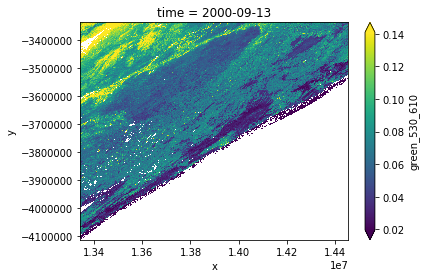

In [48]:
img.plot.imshow(robust=True)

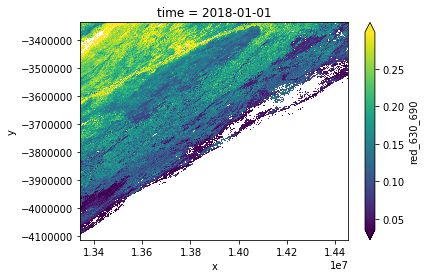

In [40]:
img.isel(y=slice(None, -3 * 240)).plot.imshow(robust=True)

In [52]:
%%time
ds_sub.to_netcdf('/g/data/oe9/project/team-drip/h30v12_reflectance.nc')

RuntimeError: NetCDF: HDF error